<a href="https://colab.research.google.com/github/kocurvik/edu/blob/master/3DV/labs/cv05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 5th Lab - Fundamental Matrix

In this lab you will implement the 7-point and 8-point algorithms along with RANSAC and test your implementation on real data.

In [ ]:
import sympy as sp
import numpy as np
import cv2
from matplotlib import pyplot as plt
from IPython.display import display

## Data and Point Correspondences

We will use two images from the TUM dataset

In [ ]:
!wget https://raw.githubusercontent.com/kocurvik/edu/master/3DV/labs/resources/cv05_img_1.png
!wget https://raw.githubusercontent.com/kocurvik/edu/master/3DV/labs/resources/cv05_img_2.png
!wget https://raw.githubusercontent.com/kocurvik/edu/master/3DV/labs/resources/cv05_gt.txt
!cat cv05_gt.txt

--2023-03-14 17:15:43--  https://raw.githubusercontent.com/kocurvik/edu/master/3DV/labs/resources/cv05_img_1.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 494694 (483K) [image/png]
Saving to: ‘cv05_img_1.png.3’

cv05_img_1.png.3    100%[===================>] 483.10K  --.-KB/s    in 0.01s   

2023-03-14 17:15:43 (36.6 MB/s) - ‘cv05_img_1.png.3’ saved [494694/494694]

--2023-03-14 17:15:44--  https://raw.githubusercontent.com/kocurvik/edu/master/3DV/labs/resources/cv05_img_2.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 

We can obtain ground truth for a pair of images from the TUM SLAM dataset. We can also generate random noisy data to verify our algorithm.

In [ ]:
from scipy.spatial.transform import Rotation

# load data from TUM dataset

def load_real_image_correspondences():
  # Loads two images, ground truth and correspondences
  # returns:
  # p - (N, 2) array with pixel coordinates with points matched in first image
  # q - (N, 2) array with pixel coordinates with points matched in second image
  # gt_K - (3, 3) array with the ground truth intrinsic matrix
  # gt_R - (3, 3) array with the ground truth rotation matrix
  # gt_t - (3,) array with the ground truth translation

  gt_data = np.loadtxt('cv05_gt.txt', skiprows=1, delimiter=' ')

  img1 = cv2.imread('cv05_img_1.png')
  img2 = cv2.imread('cv05_img_2.png')

  plt.imshow(img1[:, :, ::-1])
  plt.show()
  plt.imshow(img2[:, :, ::-1])
  plt.show()

  gt_t_1 = gt_data[0, 1:4]
  gt_t_2 = gt_data[1, 1:4]
  gt_1_quat = gt_data[0, 4:]
  gt_2_quat = gt_data[1, 4:]

  gt_R_1 = Rotation.from_quat(gt_1_quat).as_matrix()
  gt_R_2 = Rotation.from_quat(gt_2_quat).as_matrix()


  T_1 = np.zeros((4, 4))
  T_1[3, 3] = 1
  T_1[:3, 3] = gt_t_1
  T_1[:3, :3] = gt_R_1

  T_2 = np.zeros((4, 4))
  T_2[3, 3] = 1
  T_2[:3, 3] = gt_t_2
  T_2[:3, :3] = gt_R_2

  T = np.linalg.inv(np.linalg.inv(T_1) @ T_2)


  gt_R = T[:3, :3]
  gt_t = T[:3, -1]

  fx = 525.0  # focal length x
  fy = 525.0  # focal length y
  cx = 319.5  # optical center x
  cy = 239.5  # optical center y
  gt_K = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])

  print("GT translation: ", gt_t)
  print("GT rotation: ")
  print(gt_R)
  print("GT K: ")
  print(gt_K)

  # Initiate SIFT detector
  sift = cv2.SIFT_create()
  # find the keypoints and descriptors with SIFT
  kp1, des1 = sift.detectAndCompute(img1,None)
  kp2, des2 = sift.detectAndCompute(img2,None)
  # BFMatcher with default params
  bf = cv2.BFMatcher()
  matches = bf.knnMatch(des1,des2,k=2)
  # Apply ratio test
  good = []
  for m,n in matches:
      if m.distance < 0.75*n.distance:
          good.append([m])
  # cv.drawMatchesKnn expects list of lists as matches.
  img_matches = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
  plt.figure(figsize=[16, 6])
  plt.imshow(img_matches[:, :, ::-1])
  plt.show()

  # return as numpy arrays
  p = np.array([kp1[m[0].queryIdx].pt for m in good])
  q = np.array([kp2[m[0].trainIdx].pt for m in good])

  return p, q, gt_K, gt_R, gt_t

def generate_noisy_synthetic_data(gt_K, gt_R, gt_t, sigma=0.5):
  # Generates random noisy data
  # params:
  # gt_K - (3, 3) array with the ground truth intrinsic matrix
  # gt_R - (3, 3) array with the ground truth rotation matrix
  # gt_t - (3,) array with the ground truth translation
  # sigma - amount of noise to add to pixel coordinates
  # returns
  # p - (N, 2) array with pixel coordinates with points matched in first image
  # q - (N, 2) array with pixel coordinates with points matched in second image

  X = 100 * np.random.randn(100, 3)
  X[:, 2] += 500
  X_h = np.column_stack([X, np.ones(len(X))])

  P1 = gt_K @ np.array([[1 ,0 , 0, 0],[0, 1, 0, 0], [0, 0, 1, 0]])
  Rt2 = np.zeros([3, 4])
  Rt2[:3, :3] = gt_R
  Rt2[:, 3] = 50*gt_t
  P2 = gt_K @ Rt2

  x1_h = (P1 @ X_h.T).T
  p = x1_h[:, :2] / x1_h[:, 2, np.newaxis]
  x2_h = (P2 @ X_h.T).T
  q = x2_h[:, :2] / x2_h[:, 2, np.newaxis]

  p += sigma * np.random.randn(100, 2)
  q += sigma * np.random.randn(100, 2)
  return p, q

## Exercise - Estimate F using RANSAC with 7 point algorithm (5 points)

Your goal is to implement an algorithm which estimates F. To complete the exercise you will have to implement RANSAC with the 7-point algorithm. The algorithm takes as input the two $N \times 2$ arrays representing the matched points, number of RANSAC iterations and a threshold for inliers within RANSAC. 

The algorithm performs RANSAC to find the fundamental matrix with the most inliers. The RANSAC algorithm always selects 7 pairs of points and calculates the relevant fundamental matrices (output can contain 1, 3 or no matrices). It then checks all of the matrices calculated to check how many inliers are there in the data. To calculate inliers you calculate distance from point to a line and check whether the points are closer than a given treshold `thresh`. You can use the function `line_distance(x, l)`. This is performed a defined number of times and the best Fundamental matrix is output along with a mask of all the inliers. To pick random matches you might find `np.random.choice(..., replace=False)` useful.

To calculate the matrix you have to solve the equation

$$\text{det}(\alpha F_1 + (1 - \alpha) F_2) = 0$$

this equation may have 1 or 3 real solutions. To find them you can use the function `calculate_cubic(F_1, F_2)` provided in the code below, which outputs all of the roots inlcuding the imaginary ones.

### Bonus 8-point Algorithm (2 points)

You can improve the algorithm by performing RANSAC to find the inliers and then using only the inliers to calculate F using the 8-point algorithm. Implement it based on the lectures. Or you can also implement only the 8-point algorithm and use it within ransac to solve the first exercise for 5 points without implementing the 7-point algorithm.

### Bonus (1 point) - Obtain the coefficients using SymPy

In the code below you are given the function `calculate_cubic`. Try to find the coefficients on your own using SymPy.

### Verification

You can use the last cell of this notebook to determine the error in both translation and rotation in degrees. The test runs for both real and synthetic data.

In [ ]:
def calculate_cubic_roots(F1, F2):
  # params:
  # F1 - (3, 3) array representing F_1
  # F2 - (3, 3) array representing F_1
  # returns all roots alpha of polynomial det(alpha * F_1 + (1 - alpha) *F_2) = 0

  coeffs = np.zeros(4)
  coeffs[0] = F1[0, 0]*F1[1, 1]*F1[2, 2] - F1[0, 0]*F1[1, 1]*F2[2, 2] - F1[0, 0]*F1[1, 2]*F1[2, 1] + F1[0, 0]*F1[1, 2]*F2[2, 1] + F1[0, 0]*F1[2, 1]*F2[1, 2] - F1[0, 0]*F1[2, 2]*F2[1, 1] + F1[0, 0]*F2[1, 1]*F2[2, 2] - F1[0, 0]*F2[1, 2]*F2[2, 1] - F1[0, 1]*F1[1, 0]*F1[2, 2] + F1[0, 1]*F1[1, 0]*F2[2, 2] + F1[0, 1]*F1[1, 2]*F1[2, 0] - F1[0, 1]*F1[1, 2]*F2[2, 0] - F1[0, 1]*F1[2, 0]*F2[1, 2] + F1[0, 1]*F1[2, 2]*F2[1, 0] - F1[0, 1]*F2[1, 0]*F2[2, 2] + F1[0, 1]*F2[1, 2]*F2[2, 0] + F1[0, 2]*F1[1, 0]*F1[2, 1] - F1[0, 2]*F1[1, 0]*F2[2, 1] - F1[0, 2]*F1[1, 1]*F1[2, 0] + F1[0, 2]*F1[1, 1]*F2[2, 0] + F1[0, 2]*F1[2, 0]*F2[1, 1] - F1[0, 2]*F1[2, 1]*F2[1, 0] + F1[0, 2]*F2[1, 0]*F2[2, 1] - F1[0, 2]*F2[1, 1]*F2[2, 0] - F1[1, 0]*F1[2, 1]*F2[0, 2] + F1[1, 0]*F1[2, 2]*F2[0, 1] - F1[1, 0]*F2[0, 1]*F2[2, 2] + F1[1, 0]*F2[0, 2]*F2[2, 1] + F1[1, 1]*F1[2, 0]*F2[0, 2] - F1[1, 1]*F1[2, 2]*F2[0, 0] + F1[1, 1]*F2[0, 0]*F2[2, 2] - F1[1, 1]*F2[0, 2]*F2[2, 0] - F1[1, 2]*F1[2, 0]*F2[0, 1] + F1[1, 2]*F1[2, 1]*F2[0, 0] - F1[1, 2]*F2[0, 0]*F2[2, 1] + F1[1, 2]*F2[0, 1]*F2[2, 0] + F1[2, 0]*F2[0, 1]*F2[1, 2] - F1[2, 0]*F2[0, 2]*F2[1, 1] - F1[2, 1]*F2[0, 0]*F2[1, 2] + F1[2, 1]*F2[0, 2]*F2[1, 0] + F1[2, 2]*F2[0, 0]*F2[1, 1] - F1[2, 2]*F2[0, 1]*F2[1, 0] - F2[0, 0]*F2[1, 1]*F2[2, 2] + F2[0, 0]*F2[1, 2]*F2[2, 1] + F2[0, 1]*F2[1, 0]*F2[2, 2] - F2[0, 1]*F2[1, 2]*F2[2, 0] - F2[0, 2]*F2[1, 0]*F2[2, 1] + F2[0, 2]*F2[1, 1]*F2[2, 0]
  coeffs[1] = F1[0, 0]*F1[1, 1]*F2[2, 2] - F1[0, 0]*F1[1, 2]*F2[2, 1] - F1[0, 0]*F1[2, 1]*F2[1, 2] + F1[0, 0]*F1[2, 2]*F2[1, 1] - 2*F1[0, 0]*F2[1, 1]*F2[2, 2] + 2*F1[0, 0]*F2[1, 2]*F2[2, 1] - F1[0, 1]*F1[1, 0]*F2[2, 2] + F1[0, 1]*F1[1, 2]*F2[2, 0] + F1[0, 1]*F1[2, 0]*F2[1, 2] - F1[0, 1]*F1[2, 2]*F2[1, 0] + 2*F1[0, 1]*F2[1, 0]*F2[2, 2] - 2*F1[0, 1]*F2[1, 2]*F2[2, 0] + F1[0, 2]*F1[1, 0]*F2[2, 1] - F1[0, 2]*F1[1, 1]*F2[2, 0] - F1[0, 2]*F1[2, 0]*F2[1, 1] + F1[0, 2]*F1[2, 1]*F2[1, 0] - 2*F1[0, 2]*F2[1, 0]*F2[2, 1] + 2*F1[0, 2]*F2[1, 1]*F2[2, 0] + F1[1, 0]*F1[2, 1]*F2[0, 2] - F1[1, 0]*F1[2, 2]*F2[0, 1] + 2*F1[1, 0]*F2[0, 1]*F2[2, 2] - 2*F1[1, 0]*F2[0, 2]*F2[2, 1] - F1[1, 1]*F1[2, 0]*F2[0, 2] + F1[1, 1]*F1[2, 2]*F2[0, 0] - 2*F1[1, 1]*F2[0, 0]*F2[2, 2] + 2*F1[1, 1]*F2[0, 2]*F2[2, 0] + F1[1, 2]*F1[2, 0]*F2[0, 1] - F1[1, 2]*F1[2, 1]*F2[0, 0] + 2*F1[1, 2]*F2[0, 0]*F2[2, 1] - 2*F1[1, 2]*F2[0, 1]*F2[2, 0] - 2*F1[2, 0]*F2[0, 1]*F2[1, 2] + 2*F1[2, 0]*F2[0, 2]*F2[1, 1] + 2*F1[2, 1]*F2[0, 0]*F2[1, 2] - 2*F1[2, 1]*F2[0, 2]*F2[1, 0] - 2*F1[2, 2]*F2[0, 0]*F2[1, 1] + 2*F1[2, 2]*F2[0, 1]*F2[1, 0] + 3*F2[0, 0]*F2[1, 1]*F2[2, 2] - 3*F2[0, 0]*F2[1, 2]*F2[2, 1] - 3*F2[0, 1]*F2[1, 0]*F2[2, 2] + 3*F2[0, 1]*F2[1, 2]*F2[2, 0] + 3*F2[0, 2]*F2[1, 0]*F2[2, 1] - 3*F2[0, 2]*F2[1, 1]*F2[2, 0]
  coeffs[2] = F1[0, 0]*F2[1, 1]*F2[2, 2] - F1[0, 0]*F2[1, 2]*F2[2, 1] - F1[0, 1]*F2[1, 0]*F2[2, 2] + F1[0, 1]*F2[1, 2]*F2[2, 0] + F1[0, 2]*F2[1, 0]*F2[2, 1] - F1[0, 2]*F2[1, 1]*F2[2, 0] - F1[1, 0]*F2[0, 1]*F2[2, 2] + F1[1, 0]*F2[0, 2]*F2[2, 1] + F1[1, 1]*F2[0, 0]*F2[2, 2] - F1[1, 1]*F2[0, 2]*F2[2, 0] - F1[1, 2]*F2[0, 0]*F2[2, 1] + F1[1, 2]*F2[0, 1]*F2[2, 0] + F1[2, 0]*F2[0, 1]*F2[1, 2] - F1[2, 0]*F2[0, 2]*F2[1, 1] - F1[2, 1]*F2[0, 0]*F2[1, 2] + F1[2, 1]*F2[0, 2]*F2[1, 0] + F1[2, 2]*F2[0, 0]*F2[1, 1] - F1[2, 2]*F2[0, 1]*F2[1, 0] - 3*F2[0, 0]*F2[1, 1]*F2[2, 2] + 3*F2[0, 0]*F2[1, 2]*F2[2, 1] + 3*F2[0, 1]*F2[1, 0]*F2[2, 2] - 3*F2[0, 1]*F2[1, 2]*F2[2, 0] - 3*F2[0, 2]*F2[1, 0]*F2[2, 1] + 3*F2[0, 2]*F2[1, 1]*F2[2, 0]
  coeffs[3] = F2[0, 0]*F2[1, 1]*F2[2, 2] - F2[0, 0]*F2[1, 2]*F2[2, 1] - F2[0, 1]*F2[1, 0]*F2[2, 2] + F2[0, 1]*F2[1, 2]*F2[2, 0] + F2[0, 2]*F2[1, 0]*F2[2, 1] - F2[0, 2]*F2[1, 1]*F2[2, 0]
  return np.roots(coeffs)

In [ ]:
def line_distance(x, l):
  # params:
  # x - (n, 3) points in homogeneous coordinates, last column must be 1
  # l - (n, 3) lines in homogeneous coordinates
  # returns array of shape (n,) with distances from points to lines
  return np.abs(np.sum(x * l, axis=1))/np.sqrt(l[:, 0] ** 2 + l[:, 1] ** 2)

In [ ]:
def seven_point(p, q):
  # params:
  # p - (n, 2) array cointaing poitns x
  # q - (n, 2) array containig points x'
  # returns:
  # Fs - list of (3,3) arrays representing fumdanetal matrices such that x'^T F x = 0

  raise NotImplementedError  

In [ ]:
def ransac(p, q, n_iter, thresh):
  # params:
  # p - (N, 2) array containing image coordinates of x
  # q - (N, 1) array containing image coordinates of x'
  # n_iter - int number of iterations of RANSAC
  # thresh - threshold to consider as inlier
  # returns:
  # F - F with the most inliers
  # inliers - (n,) logical array with true values at position where distance for output F was below threshold

  raise NotImplementedError  


In [ ]:
def eight_point(p, q):
  # params:
  # p - (n, 2) array cointaing poitns x
  # q - (n, 2) array containig points x'
  # returns:
  # Fs - list of (3,3) arrays representing fumdanetal matrices such that x'^T F x = 0
  raise NotImplementedError  

In [ ]:
def rotation_error(R1, R2):
  # params:
  # R1 - (3, 3) array representing a rotation matrix
  # R2 - (3, 3) array representing a rotation matrix
  # returns:
  # angle - angle between the two rotations in degrees

  R_d = R1.T @ R2
  error = np.arccos((np.trace(R_d) - 1)/2) * 180 / np.pi
  return error

def translation_error(t1, t2):
  # params:
  # t1 - (n,) array representing a vector
  # t2 - (n,) array representing a vector
  # returns:
  # angle - angle between the two vectors in degrees
  
  return 180 /np.pi * np.arccos(np.dot(t1, t2) / (np.linalg.norm(t1) * np.linalg.norm(t2)))

def get_errs(F, gt_K, gt_R, gt_t):
  # params:
  # F - (3, 3) array with the estimated fundamental matrix
  # gt_K - (3, 3) array with the ground truth intrinsic matrix
  # gt_R - (3, 3) array with the ground truth rotation matrix
  # gt_t - (3,) array with the ground truth translation
  # returns:
  # R_err - rotation error in degrees
  # t_err - translation error in degrees
  
  E = gt_K.T @ F @ gt_K
  R1, R2, t = cv2.decomposeEssentialMat(E)
  t = t.ravel()
  R_err = min(rotation_error(R1, gt_R), rotation_error(R2, gt_R))
  print(gt_R)
  t_err = min(translation_error(t, gt_t), translation_error(-t, gt_t))

  return R_err, t_err

In [ ]:
def evaluate_f(p, q, gt_K, gt_R, gt_t):
  # params:
  # p - (n, 2) array cointaing poitns x
  # q - (n, 2) array containig points x'
  # gt_K - (3, 3) array with the ground truth intrinsic matrix
  # gt_R - (3, 3) array with the ground truth rotation matrix
  # gt_t - (3,) array with the ground truth translation
  # function:
  # Estimates F using the OpenCV and implemented algorithm and prints out the resulting errors

  F_cv, _ = cv2.findFundamentalMat(p, q)
  R_err, t_err = get_errs(F_cv, gt_K, gt_R, gt_t)
  print("Rotation error for OpenCV implementation: {} degrees".format(R_err))
  print("Translation error for OpenCV implementation: {} degrees".format(t_err))
  print(20 * '*')

  try:
    F_ransac, inliers = ransac(p, q, 200, 0.5)
    print("Found {}/{} inliers".format(np.sum(inliers), len(p)))
    R_err, t_err = get_errs(F_ransac, gt_K, gt_R, gt_t)
    print("Rotation error for RANSAC: {} degrees".format(R_err))
    print("Translation error for RANSAC: {} degrees".format(t_err))
  except NotImplementedError:
    print("RANSAC + 7pt algorithm not implemented")
  print(20 * '*')
  
  try:
    F_8 = eight_point(p[inliers], q[inliers])
    R_err, t_err = get_errs(F_8, gt_K, gt_R, gt_t)
    print("Rotation error for 8 point: {} degrees".format(R_err))
    print("Translation error for 8 point: {} degrees".format(t_err))
  except NotImplementedError:
    print("8 point algorithm not implemented")
  print(40 * '*')

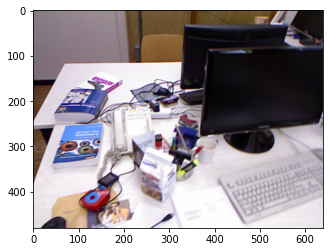

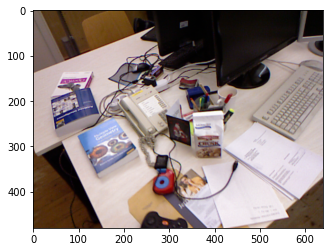

GT translation:  [ 0.34772031 -0.11379734  0.05522066]
GT rotation: 
[[ 0.88899411  0.36857059 -0.27174471]
 [-0.39727872  0.91589958 -0.05742449]
 [ 0.22772589  0.15900843  0.96065459]]
GT K: 
[[525.    0.  319.5]
 [  0.  525.  239.5]
 [  0.    0.    1. ]]


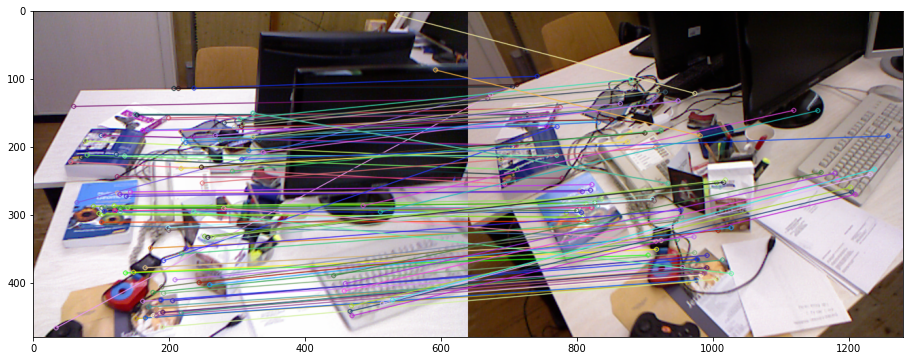

**** Real data *****
[[ 0.88899411  0.36857059 -0.27174471]
 [-0.39727872  0.91589958 -0.05742449]
 [ 0.22772589  0.15900843  0.96065459]]
Rotation error for OpenCV implementation: 5.544946222993464 degrees
Translation error for OpenCV implementation: 21.255469827069454 degrees
********************
Found 45/111 inliers
[[ 0.88899411  0.36857059 -0.27174471]
 [-0.39727872  0.91589958 -0.05742449]
 [ 0.22772589  0.15900843  0.96065459]]
Rotation error for RANSAC: 1.4875604838145113 degrees
Translation error for RANSAC: 0.8419032069283203 degrees
********************
[[ 0.88899411  0.36857059 -0.27174471]
 [-0.39727872  0.91589958 -0.05742449]
 [ 0.22772589  0.15900843  0.96065459]]
Rotation error for 8 point: 3.37365418983825 degrees
Translation error for 8 point: 16.852710997877647 degrees
****************************************
**** Synth - 0.0 sigma ****
[[ 0.88899411  0.36857059 -0.27174471]
 [-0.39727872  0.91589958 -0.05742449]
 [ 0.22772589  0.15900843  0.96065459]]
Rotation erro

<ipython-input-11-d35052244117>:9: RuntimeWarning: invalid value encountered in arccos
  error = np.arccos((np.trace(R_d) - 1)/2) * 180 / np.pi
<ipython-input-11-d35052244117>:19: RuntimeWarning: invalid value encountered in arccos
  return 180 /np.pi * np.arccos(np.dot(t1, t2) / (np.linalg.norm(t1) * np.linalg.norm(t2)))


Found 46/100 inliers
[[ 0.88899411  0.36857059 -0.27174471]
 [-0.39727872  0.91589958 -0.05742449]
 [ 0.22772589  0.15900843  0.96065459]]
Rotation error for RANSAC: 0.20382501395956623 degrees
Translation error for RANSAC: 10.592990131830566 degrees
********************
[[ 0.88899411  0.36857059 -0.27174471]
 [-0.39727872  0.91589958 -0.05742449]
 [ 0.22772589  0.15900843  0.96065459]]
Rotation error for 8 point: 1.2073209433252332 degrees
Translation error for 8 point: 45.27873958423379 degrees
****************************************
**** Synth - 1.0 sigma ****
[[ 0.88899411  0.36857059 -0.27174471]
 [-0.39727872  0.91589958 -0.05742449]
 [ 0.22772589  0.15900843  0.96065459]]
Rotation error for OpenCV implementation: 0.8036056799355749 degrees
Translation error for OpenCV implementation: 26.23734214036828 degrees
********************
Found 30/100 inliers
[[ 0.88899411  0.36857059 -0.27174471]
 [-0.39727872  0.91589958 -0.05742449]
 [ 0.22772589  0.15900843  0.96065459]]
Rotation er

In [ ]:
p, q, gt_K, gt_R, gt_t = load_real_image_correspondences()
print("**** Real data *****")
evaluate_f(p, q, gt_K, gt_R, gt_t)

for sigma in [0.0, 0.1, 0.5, 1.0, 2]:
  p, q = generate_noisy_synthetic_data(gt_K, gt_R, gt_t, sigma=sigma)
  print("**** Synth - {} sigma ****".format(sigma))
  evaluate_f(p, q, gt_K, gt_R, gt_t)